In [43]:
# Enable autoreloading (https://stackoverflow.com/a/5399339)
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, List, Union
Numeric = Union[int, float, np.number] # create generic numeric type (excluding complex numbers)

import my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# Collection of samples containing rgb-values for yellow tape
yellow_tape_rgb_values = np.array([
    (241, 237, 86),
    (247, 253, 75),
    (245, 250, 52),
    (251, 239, 78),
    (254, 255, 86),
    (242, 251, 68),

    (245, 233, 127),
    (247, 239, 156),
    (253, 252, 153),
    (252, 222, 101),
    (250, 223, 91),

    (239, 197, 48),
    (231, 197, 20),
    (243, 210, 99),

    (253, 203, 63),
    (246, 209, 69),
    (251, 211, 79),
    (251, 222, 100),
    (247, 214, 55),
    (247, 205, 49),

    (160, 167, 21),
    (172, 177, 43),

    (253, 217, 69),
    (245, 215, 23),
    (230, 221, 25),
    (245, 219, 39),
    (233, 232, 123),
    (251, 249, 145),

    (250, 209, 24),
    (253, 217, 51),
    (237, 217, 0),
    (236, 219, 5),
    (255, 227, 6),
    (246, 208, 0),
    (224, 175, 15),
    (240, 201, 9),

    (200, 196, 98),
    (176, 156, 44),
    (213, 187, 64),

    (255, 239, 82),
    (255, 233, 72),
    (255, 218, 50),
    (226, 189, 29),
    (198, 159, 18),
    (255, 239, 80),
    (241, 205, 47),
    (199, 163, 24),

    (203, 217, 105),
    (215, 219, 106),
    (226, 228, 109),
    (228, 228, 117)
])


yellow_tape_hsv_values = np.apply_along_axis(my_utils.rgb_to_cv2_hsv, axis=-1, arr=yellow_tape_rgb_values)

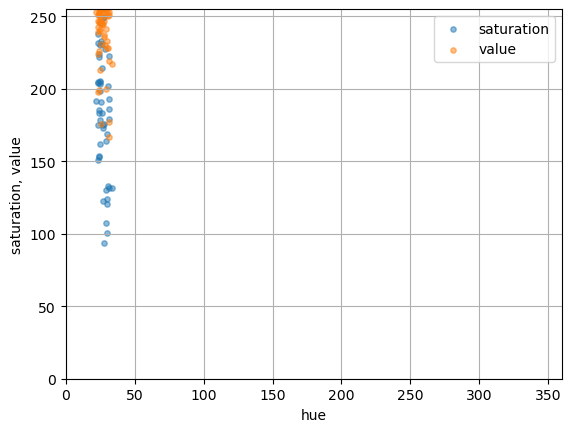

In [45]:
plt.scatter(yellow_tape_hsv_values[:, 0], yellow_tape_hsv_values[:, 1], s=15, alpha=0.5, label='saturation')
plt.scatter(yellow_tape_hsv_values[:, 0], yellow_tape_hsv_values[:, 2], s=15, alpha=0.5, label='value')
plt.grid()
plt.xlabel('hue')
plt.ylabel('saturation, value')
plt.xlim((0, 360))
plt.ylim((0, 255))
plt.legend()
plt.show()

In [23]:
def segment_image_by_hsv_range(img_bgr: np.array, hsv_min: Tuple[Numeric, Numeric, Numeric], hsv_max: Tuple[Numeric, Numeric, Numeric]) -> np.array:
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    segmentation_mask = cv2.inRange(img_hsv, hsv_min, hsv_max)
    return segmentation_mask

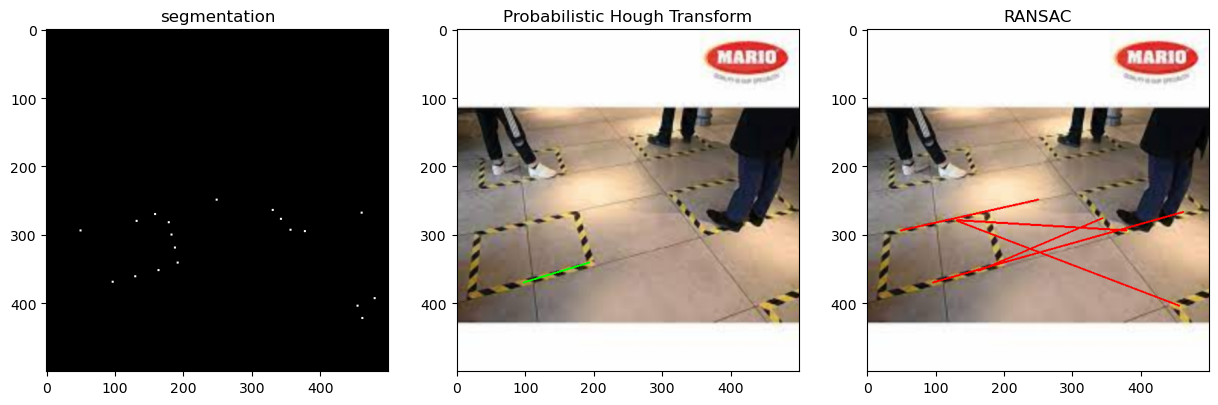

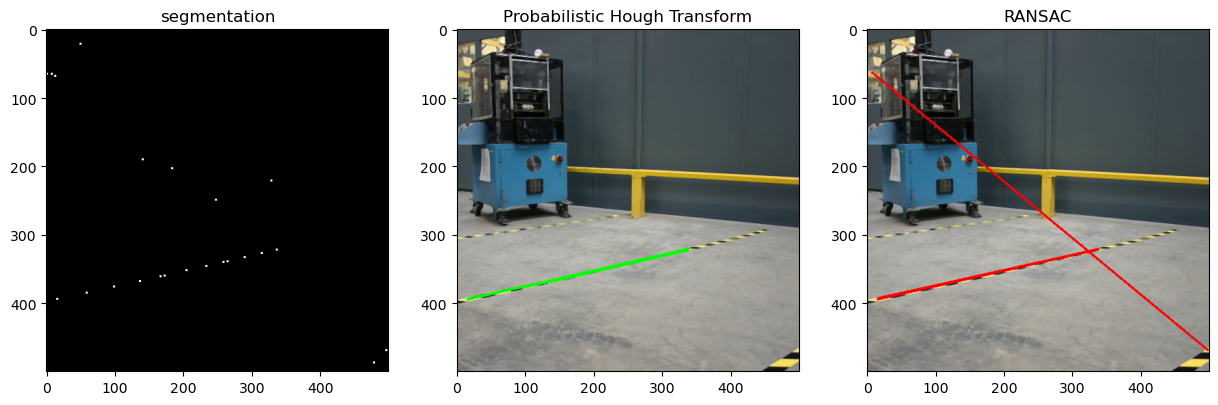

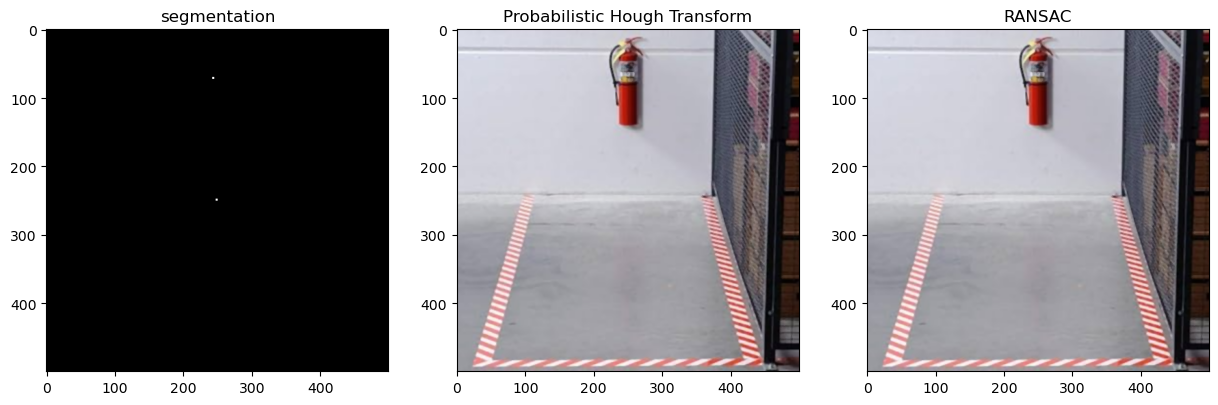

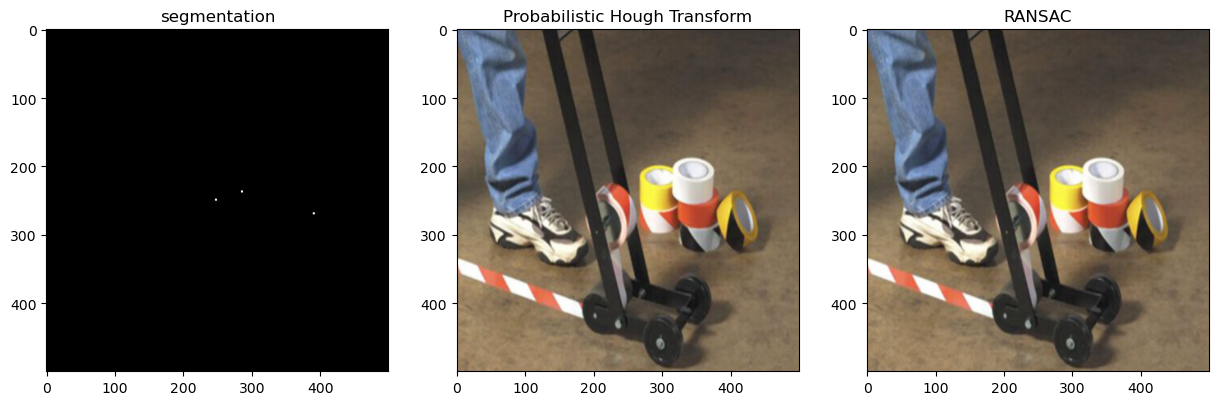

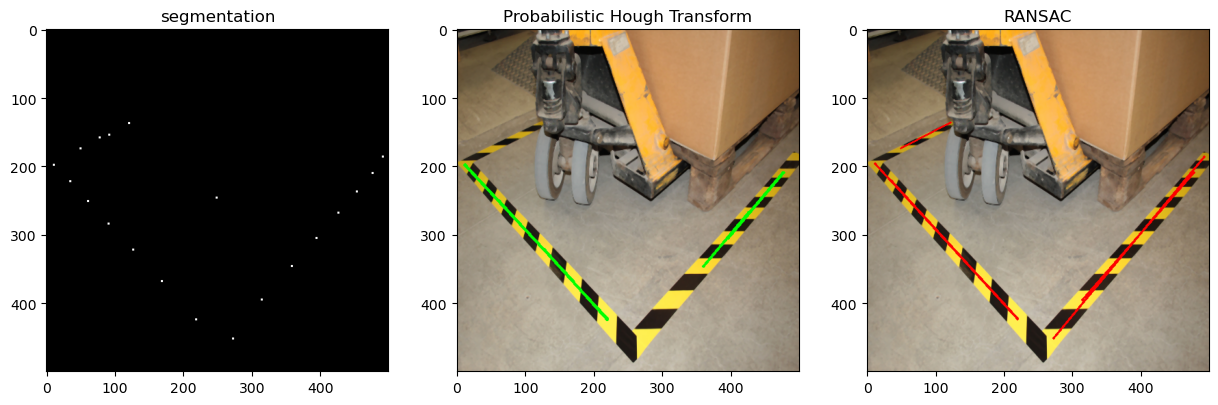

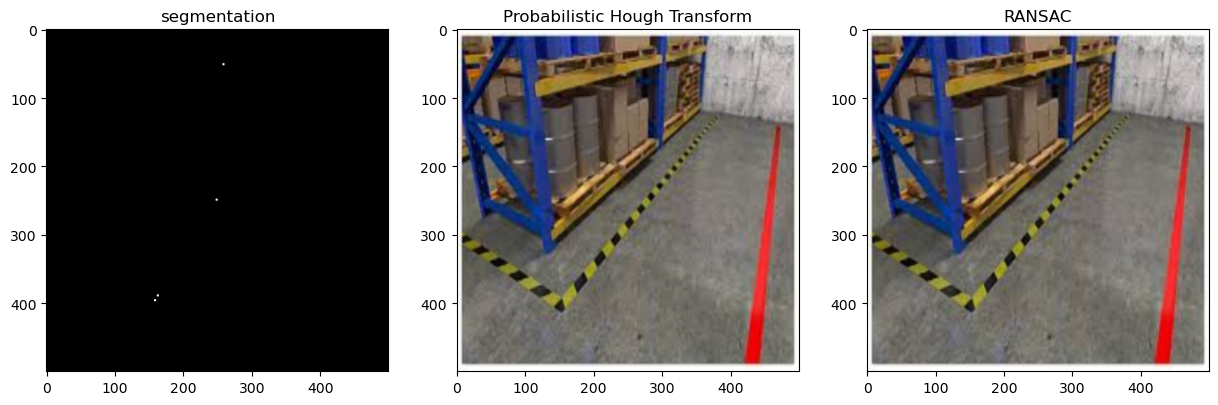

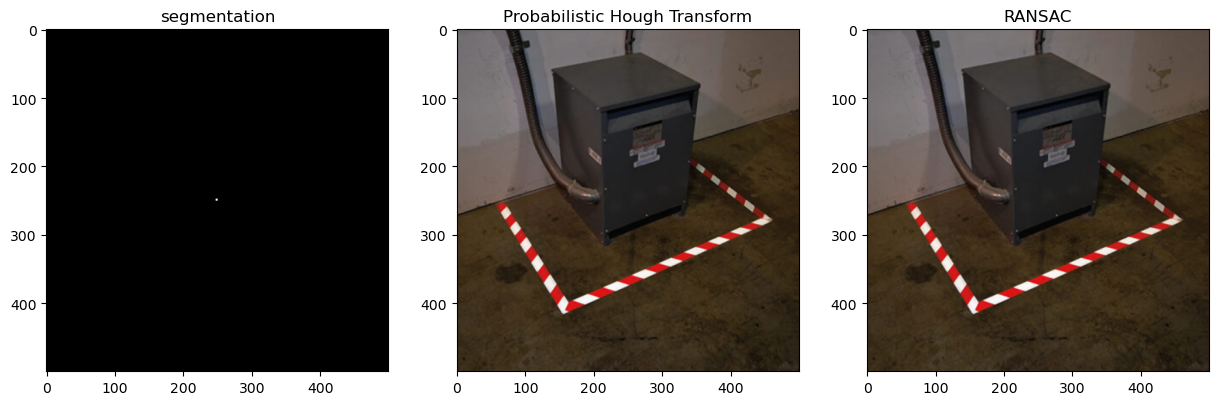

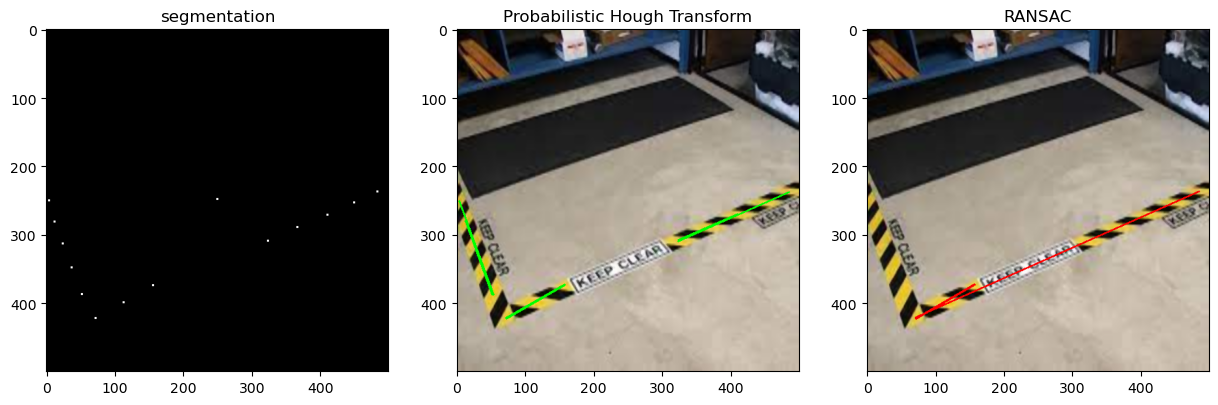

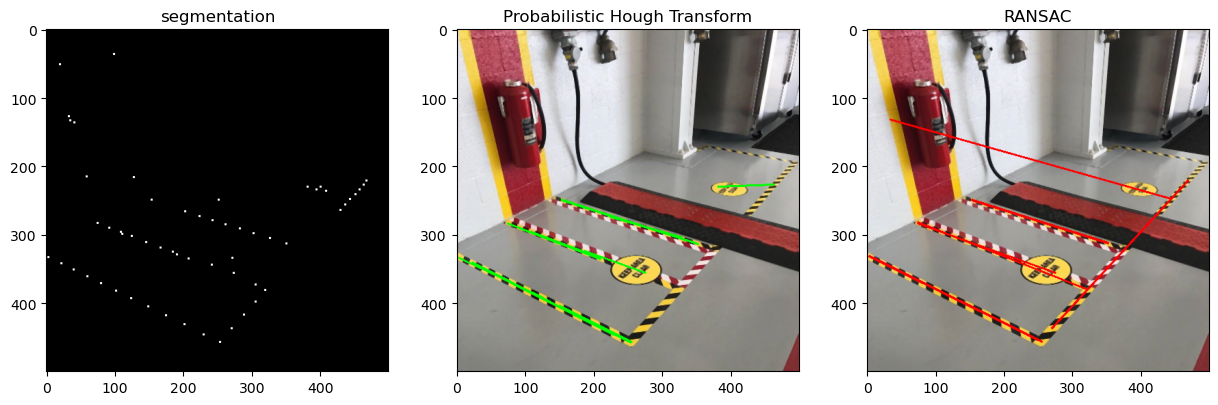

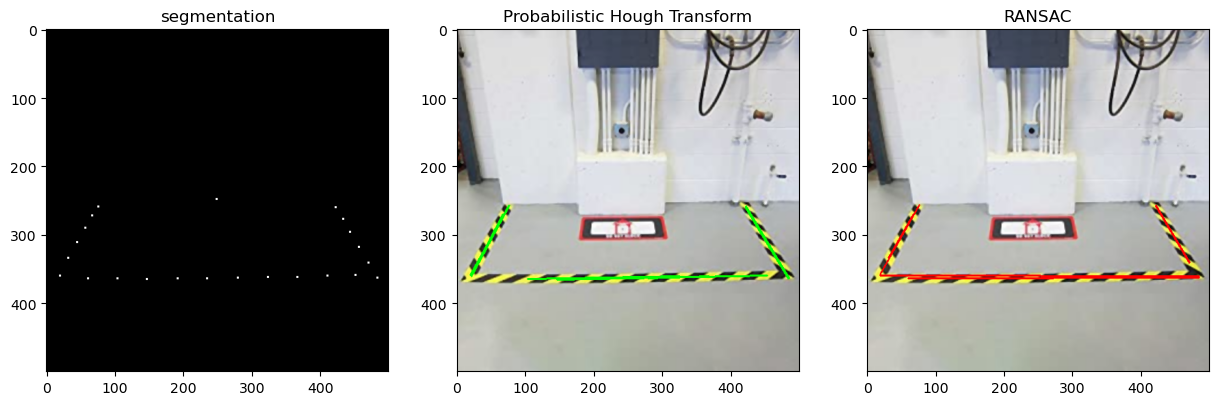

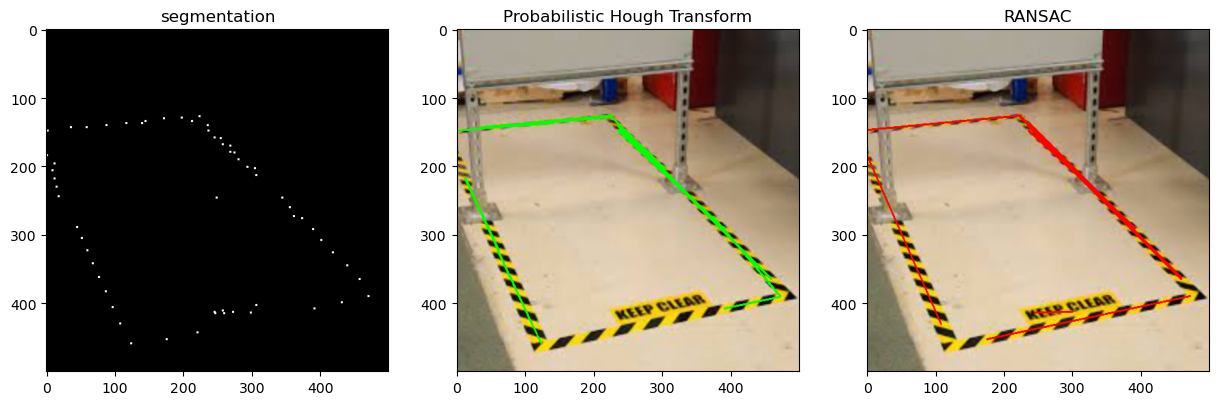

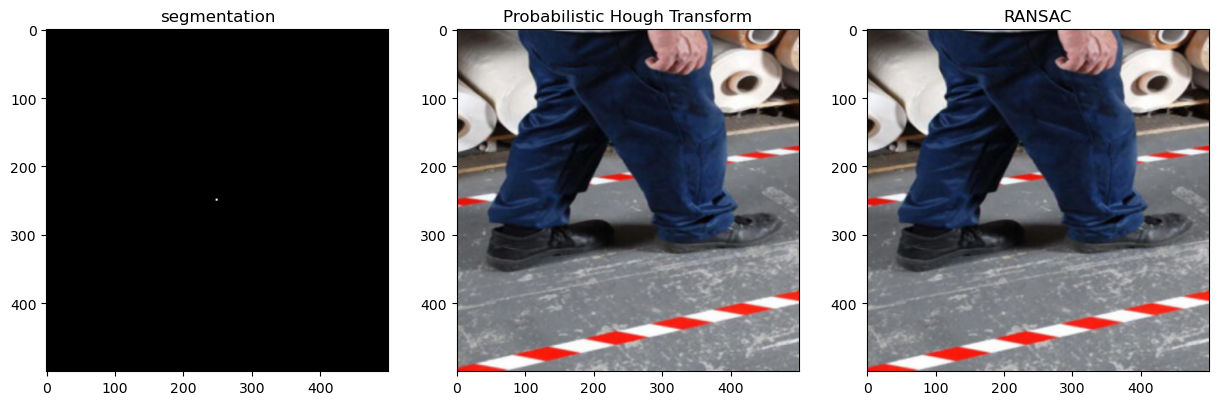

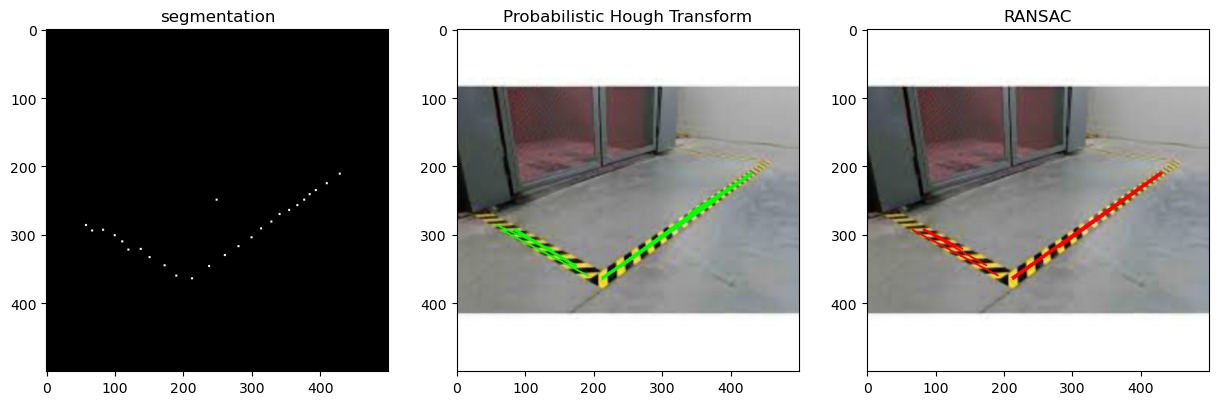

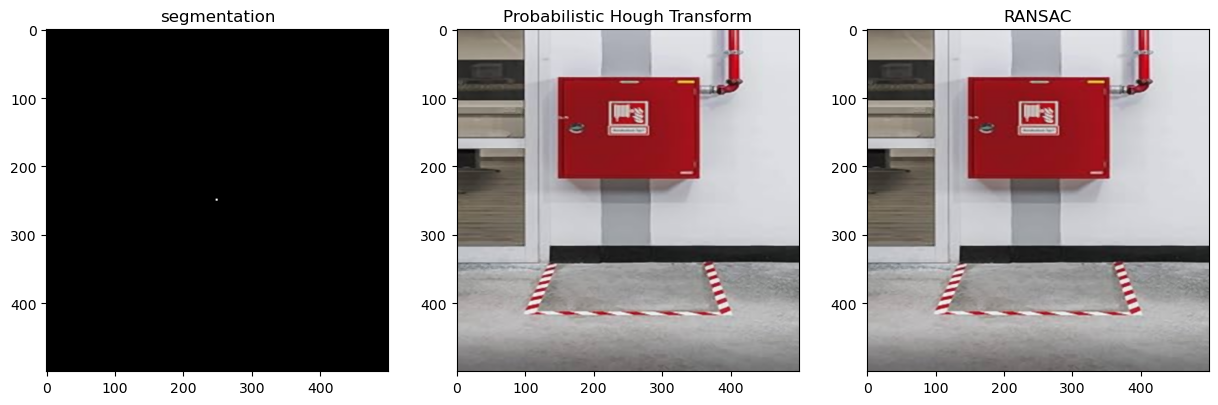

In [55]:
# define color-range for tape-segmentation
tape_red_min_cv2_hsv = (22, 100, 170)
tape_red_max_cv2_hsv = (32, 255, 255)


img_paths = my_utils.find_files_by_ext('../data/test_images/')
for img_path in img_paths: 
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f'{str(img_path)} could not be opened!')
        continue
    img_bgr = cv2.resize(img_bgr, (500, 500))
    img_bgr = cv2.medianBlur(img_bgr, 3)
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    mask_red = segment_image_by_hsv_range(img_bgr, tape_red_min_cv2_hsv, tape_red_max_cv2_hsv)
    if mask_red is None:
        continue
    kernel = np.ones((3,3), np.uint8)
    mask_red = cv2.erode(mask_red, kernel, iterations=1)

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_red)
    # Create a new blank mask
    mask = np.zeros_like(mask_red)
    # Draw the centroid of each component as a single pixel
    for c in centroids:
        cx, cy = int(c[0]), int(c[1])
        mask[cy, cx] = 255

    kernel = np.ones((3,3), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)

    # Detect line segments using Probabilistic Hough Transform
    lines_hough = cv2.HoughLinesP(mask, 1, np.deg2rad(1), threshold=6, minLineLength=80, maxLineGap=70)
    if lines_hough is not None:
        lines_hough = lines_hough.reshape((lines_hough.shape[0], 4))

    lines_ransac = my_utils.iterative_RANSAC(mask, min_samples=2, min_inliers=15, residual_threshold=1, max_trials=1000)

    # Draw line segments on the original image (green=Hough, red=RANSAC)
    out_img_hough_bgr = img_bgr.copy()
    out_img_ransac_bgr = img_bgr.copy()
    for lines, color, out_img in [(lines_hough, (0, 255, 0), out_img_hough_bgr), (lines_ransac, (0, 0, 255), out_img_ransac_bgr)]:
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line
                cv2.line(out_img, (x1, y1), (x2, y2), color, 2)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(mask, cmap='gray')
    axes[0].set_title('segmentation')

    axes[1].imshow(cv2.cvtColor(out_img_hough_bgr, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Probabilistic Hough Transform')

    axes[2].imshow(cv2.cvtColor(out_img_ransac_bgr, cv2.COLOR_BGR2RGB))
    axes[2].set_title('RANSAC')
